# Hospital Readmission Risk Prediction

**Goal**: *Predict whether a patient will be readmitted within 30 days of discharge.*

**Dataset**: *100k+ hospital encounters (UCI Diabetes 130-US hospitals dataset)*

In [22]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, cross_val_predict
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                             confusion_matrix, classification_report, 
                             precision_recall_curve, roc_curve)
from sklearn.calibration import calibration_curve
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## Load and Inspect Data

In [23]:
data = pd.read_csv("data/diabetic_data.csv")
ids_map = pd.read_csv("data/IDS_mapping.csv")

df = data.copy()
print(f"Dataset Shape: {df.shape}")
display(df.head())

Dataset Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [24]:
print(f"Target distribution:\n{df['readmitted'].value_counts(normalize=True)}")

Target distribution:
readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


In [25]:
# Replace '?' with NaN
df = df.replace('?', np.nan)

# Initial missingness analysis
missing_summary = (df.isna().sum()/len(df)*100).sort_values(ascending=False)
print(f"\nTop 12 missing columns:\n{missing_summary.head(12)}")


Top 12 missing columns:
weight               96.858479
max_glu_serum        94.746772
A1Cresult            83.277322
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
encounter_id          0.000000
troglitazone          0.000000
tolbutamide           0.000000
dtype: float64


## Data Cleaning and Preprocessing

In [26]:
# Drop identifiers and problematic columns
df = df.drop(columns=['encounter_id', 'weight', 'max_glu_serum', 'payer_code'])

# Handle missing values strategically
df['A1Cresult'] = df['A1Cresult'].fillna('None')
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
df['race'] = df['race'].fillna('Unknown')
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown')

## Feature Engineering

### Engineering Target Variable

In [27]:
# Create multiple target formulations for comparison
df['readmit_30_binary'] = (df['readmitted'] == '<30').astype(int)
df['readmit_any'] = (df['readmitted'] != 'NO').astype(int)

print(f"Binary target distribution (<30 vs rest):")
print(df['readmit_30_binary'].value_counts(normalize=True))

Binary target distribution (<30 vs rest):
readmit_30_binary
0    0.888401
1    0.111599
Name: proportion, dtype: float64


### Temporal-Safe Feature Engineering

In [28]:
# Age conversion
def age_to_mid(a):
    try:
        a = str(a).strip('[]()')
        lo, hi = a.split('-')
        return (int(lo) + int(hi)) / 2
    except:
        return np.nan

df['age_num'] = df['age'].apply(age_to_mid)
df = df.drop(columns=['age'])

In [29]:
# Diagnosis grouping function
def diag_group_expanded(code):
    try:
        c = float(code)
        if 1 <= c <= 139: return 'infectious'
        if 140 <= c <= 239: return 'neoplasms'
        if (240 <= c < 250) or (251 <= c <= 279): return 'endocrine_other'
        if 250 <= c < 251: return 'diabetes'
        if 280 <= c <= 289: return 'blood'
        if 290 <= c <= 319: return 'mental'
        if 320 <= c <= 389: return 'neurological'
        if (390 <= c <= 459) or c == 785: return 'circulatory'
        if (460 <= c <= 519) or c == 786: return 'respiratory'
        if (520 <= c <= 579) or c == 787: return 'digestive'
        if (580 <= c <= 629) or c == 788: return 'genitourinary'
        if 630 <= c <= 679: return 'pregnancy'
        if 680 <= c <= 709: return 'skin'
        if 710 <= c <= 739: return 'musculoskeletal'
        if 740 <= c <= 759: return 'congenital'
        if 760 <= c <= 779: return 'perinatal'
        if 780 <= c <= 799: return 'symptoms'
        if 800 <= c <= 999: return 'injury'
        return 'other'
    except:
        return 'unknown'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col + '_group'] = df[col].apply(diag_group_expanded)

# Drop raw diagnosis columns
df = df.drop(columns=['diag_1', 'diag_2', 'diag_3'])

### Medication-Feature Engineering

In [30]:
# Medication columns
med_cols = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'examide','citoglipton','insulin','glyburide-metformin',
    'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
    'metformin-pioglitazone'
]
med_cols = [c for c in med_cols if c in df.columns]

def med_to_int(val):
    if pd.isna(val): return 0
    v = str(val).strip().lower()
    if v in ['no', 'none']: return 0
    if v in ['steady', 'steady.']: return 1
    if v in ['up', 'up.']: return 2
    if v in ['down', 'down.']: return -1
    return 0

for c in med_cols:
    df[c + '_code'] = df[c].apply(med_to_int)

In [31]:
# Medication summary features
med_code_cols = [c for c in df.columns if c.endswith('_code')]

df['num_medications_steady'] = df[med_code_cols].apply(lambda x: (x == 1).sum(), axis=1)
df['num_medications_changed'] = df[med_code_cols].apply(lambda x: ((x == 2) | (x == 3)).sum(), axis=1)
df['any_med_change'] = (df['num_medications_changed'] > 0).astype(int)
df['on_insulin'] = (df['insulin_code'] > 0).astype(int)

# Drop original medication columns
df = df.drop(columns=med_cols)

### Additional Feature Engineering

In [32]:
# Binary flags
df['change_flag'] = df['change'].astype(str).str.lower().map(
    lambda x: 0 if x in ['no', 'no change', 'none'] else 1
).astype(int)

df['diabetesMed_flag'] = (
    df['diabetesMed'].astype(str).str.lower().map({'yes': 1, 'no': 0}).fillna(0)
).astype(int)

# Clinical summary features (TEMPORAL-SAFE)
df['long_stay'] = (df['time_in_hospital'] > 7).astype(int)
df['many_procedures'] = (df['num_procedures'] > 2).astype(int)
df['many_medications'] = (df['num_medications'] > 8).astype(int)
df['many_diagnoses'] = (df['number_diagnoses'] > 8).astype(int)
df['high_lab_work'] = (df['num_lab_procedures'] > df['num_lab_procedures'].median()).astype(int)

# Drop original columns we've engineered from
df = df.drop(columns=['change', 'diabetesMed'])

### Categorical Variable Encoding

In [33]:
# Select categorical columns for encoding
cat_cols = [
    'race', 'gender', 'medical_specialty', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id', 'A1Cresult',
    'diag_1_group', 'diag_2_group', 'diag_3_group'
]
cat_cols = [c for c in cat_cols if c in df.columns]

# Label encode all categorical variables
categorical_mappings = {}
for c in cat_cols:
    df[c] = df[c].fillna('Unknown').astype(str)
    codes, uniques = pd.factorize(df[c], sort=True)
    df[c + '_enc'] = codes
    categorical_mappings[c] = list(uniques)

## Feature Selection

In [34]:
# Define feature sets
base_features = [
    'age_num', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_diagnoses'
]

engineered_features = [
    'num_medications_steady', 'num_medications_changed', 'any_med_change',
    'on_insulin', 'change_flag', 'diabetesMed_flag', 'long_stay',
    'many_procedures', 'many_medications', 'many_diagnoses', 'high_lab_work'
]

categorical_features = [c + '_enc' for c in cat_cols]
medication_features = med_code_cols

# Combine all features
all_features = base_features + engineered_features + categorical_features + medication_features
all_features = [f for f in all_features if f in df.columns]

print(f"Total features selected: {len(all_features)}")

Total features selected: 50


In [35]:
# Create final datasets
X = df[all_features].copy()
y_binary = df['readmit_30_binary'].copy()  # Primary target
y_any = df['readmit_any'].copy()           # Secondary target
groups = df['patient_nbr'].copy()

## Patient-Wise Data Splitting

In [36]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y_binary, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train_binary, y_test_binary = y_binary.iloc[train_idx], y_binary.iloc[test_idx]
y_train_any, y_test_any = y_any.iloc[train_idx], y_any.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

print(f"Train size: {X_train.shape[0]} (patients: {groups_train.nunique()})")
print(f"Test size:  {X_test.shape[0]} (patients: {groups_test.nunique()})")
print(f"Train target distribution: {y_train_binary.value_counts(normalize=True).round(3)}")

Train size: 81613 (patients: 57214)
Test size:  20153 (patients: 14304)
Train target distribution: readmit_30_binary
0    0.887
1    0.113
Name: proportion, dtype: float64


## Model Training with CV

In [37]:
def train_evaluate_model(X_train, X_test, y_train, y_test, target_name):
    """Train and evaluate model for a specific target"""
    
    # Calculate class weights
    pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
    
    # LightGBM parameters
    params = {
        'objective': 'binary',
        'metric': ['auc', 'average_precision'],
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'scale_pos_weight': pos_weight,
        'random_state': 42,
        'verbose': -1
    }
    
    # Create datasets
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
    
    # Train model
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
        ]
    )
    
    return model

In [38]:
# Train for binary target (<30 days)
print("Training model for <30 day readmission...")
model_binary = train_evaluate_model(X_train, X_test, y_train_binary, y_test_binary, "<30 days")

# Train for any readmission target
print("Training model for any readmission...")
model_any = train_evaluate_model(X_train, X_test, y_train_any, y_test_any, "Any readmission")

Training model for <30 day readmission...
Training model for any readmission...


## Comprehensive Evaluation

In [39]:
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    
    # Predictions
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    
    # Find optimal threshold using PR curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
    y_pred_default = (y_pred_prob >= 0.5).astype(int)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    pr_auc = average_precision_score(y_test, y_pred_prob)
    
    # Default threshold metrics
    cm_default = confusion_matrix(y_test, y_pred_default)
    report_default = classification_report(y_test, y_pred_default, output_dict=True)
    
    # Optimal threshold metrics
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    report_optimal = classification_report(y_test, y_pred_optimal, output_dict=True)
    
    print(f"\n{'='*50}")
    print(f"MODEL: {model_name}")
    print(f"{'='*50}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"Optimal threshold: {optimal_threshold:.3f}")
    
    print(f"\nDEFAULT THRESHOLD (0.5):")
    print(f"Precision: {report_default['1']['precision']:.3f}")
    print(f"Recall:    {report_default['1']['recall']:.3f}")
    print(f"F1:        {report_default['1']['f1-score']:.3f}")
    
    print(f"\nOPTIMAL THRESHOLD ({optimal_threshold:.3f}):")
    print(f"Precision: {report_optimal['1']['precision']:.3f}")
    print(f"Recall:    {report_optimal['1']['recall']:.3f}")
    print(f"F1:        {report_optimal['1']['f1-score']:.3f}")
    
    return {
        'model': model,
        'y_pred_prob': y_pred_prob,
        'y_test': y_test,
        'optimal_threshold': optimal_threshold,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'cm_default': cm_default,
        'cm_optimal': cm_optimal
    }

# Evaluate both models
results_binary = evaluate_model(model_binary, X_test, y_test_binary, "<30 Day Readmission")
results_any = evaluate_model(model_any, X_test, y_test_any, "Any Readmission")


MODEL: <30 Day Readmission
ROC-AUC: 0.6392
PR-AUC:  0.1775
Optimal threshold: 0.519

DEFAULT THRESHOLD (0.5):
Precision: 0.148
Recall:    0.584
F1:        0.236

OPTIMAL THRESHOLD (0.519):
Precision: 0.158
Recall:    0.523
F1:        0.243

MODEL: Any Readmission
ROC-AUC: 0.6687
PR-AUC:  0.6035
Optimal threshold: 0.356

DEFAULT THRESHOLD (0.5):
Precision: 0.560
Recall:    0.688
F1:        0.618

OPTIMAL THRESHOLD (0.356):
Precision: 0.500
Recall:    0.924
F1:        0.649


## Feature Importance Analysis

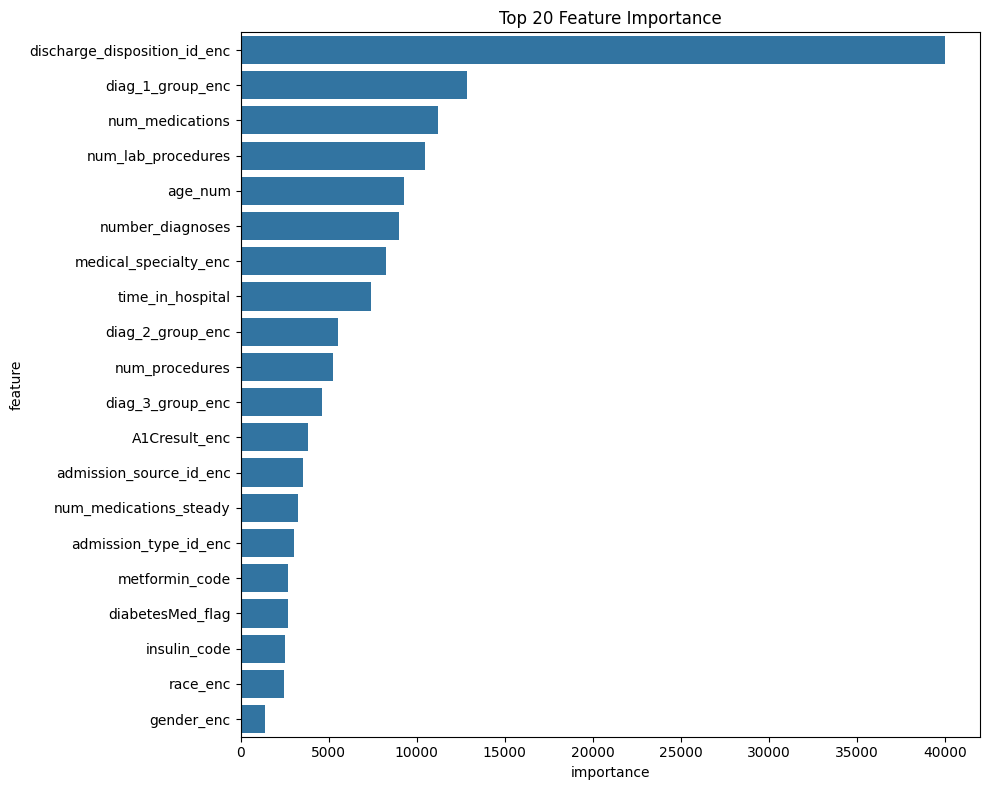

In [40]:
def plot_feature_importance(model, feature_names, top_n=20):
    """Plot feature importance"""
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, y='feature', x='importance')
    plt.title(f'Top {top_n} Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Plot importance for binary model
importance_binary = plot_feature_importance(model_binary, all_features)

## Comprehensive Visualizations

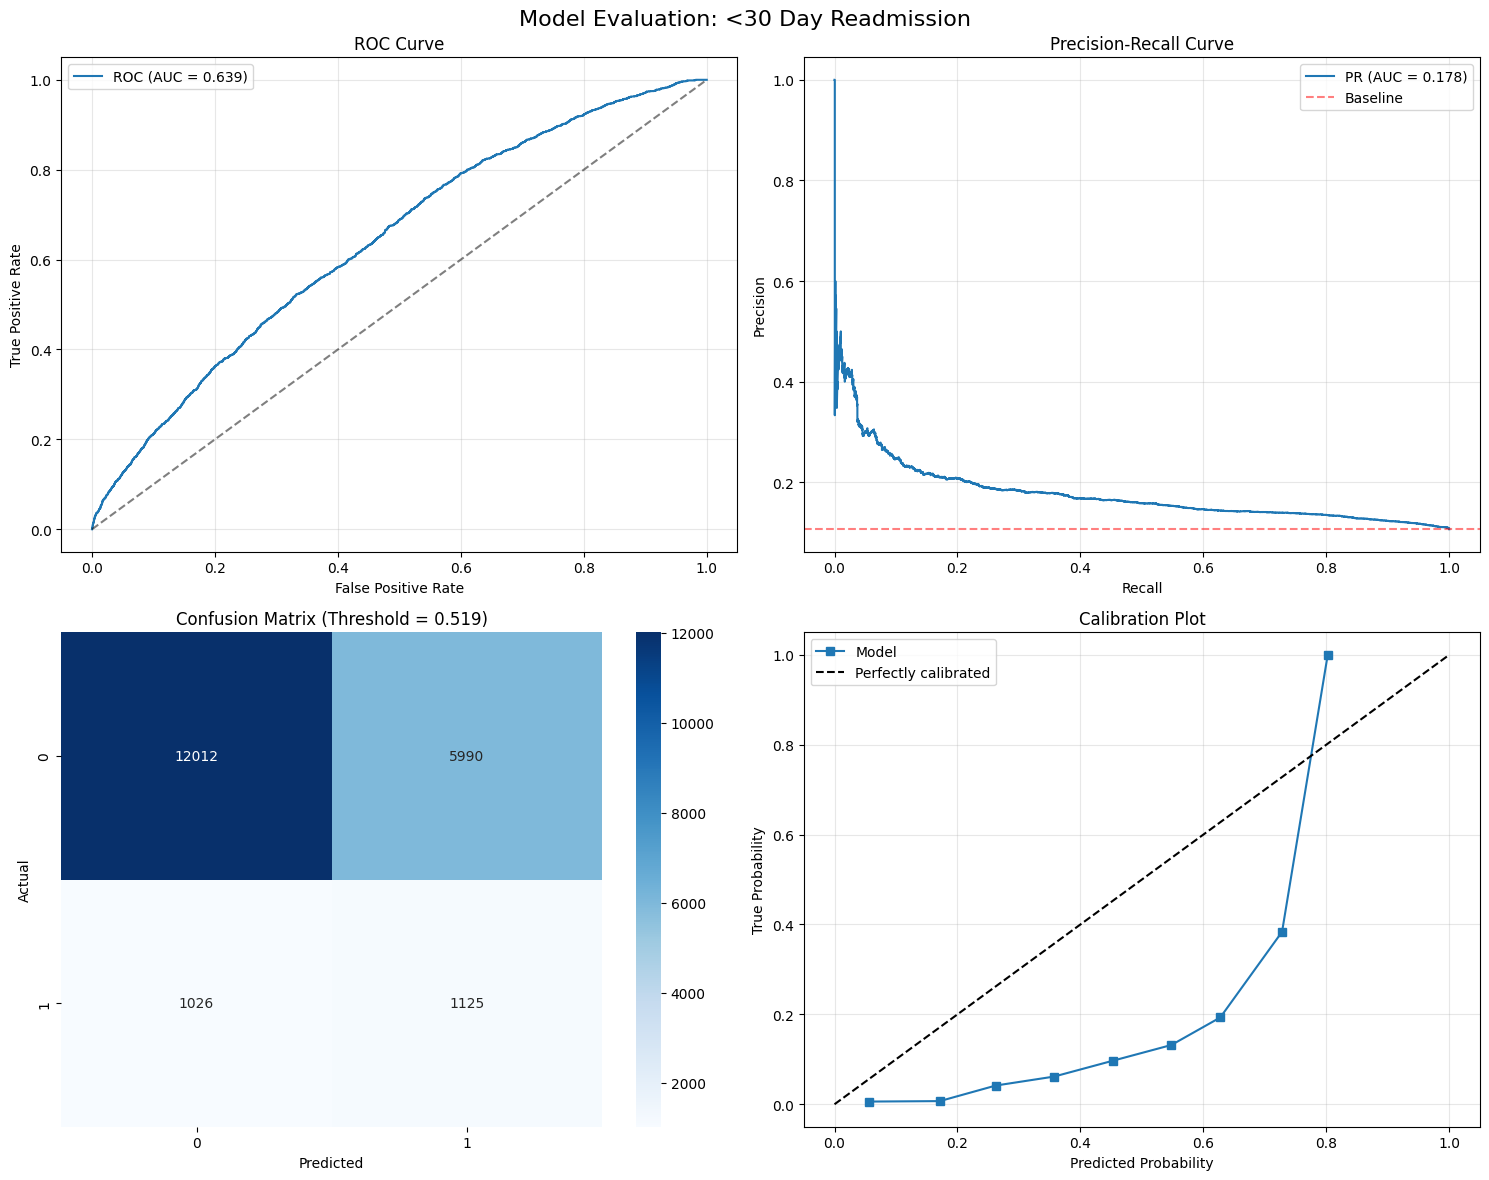

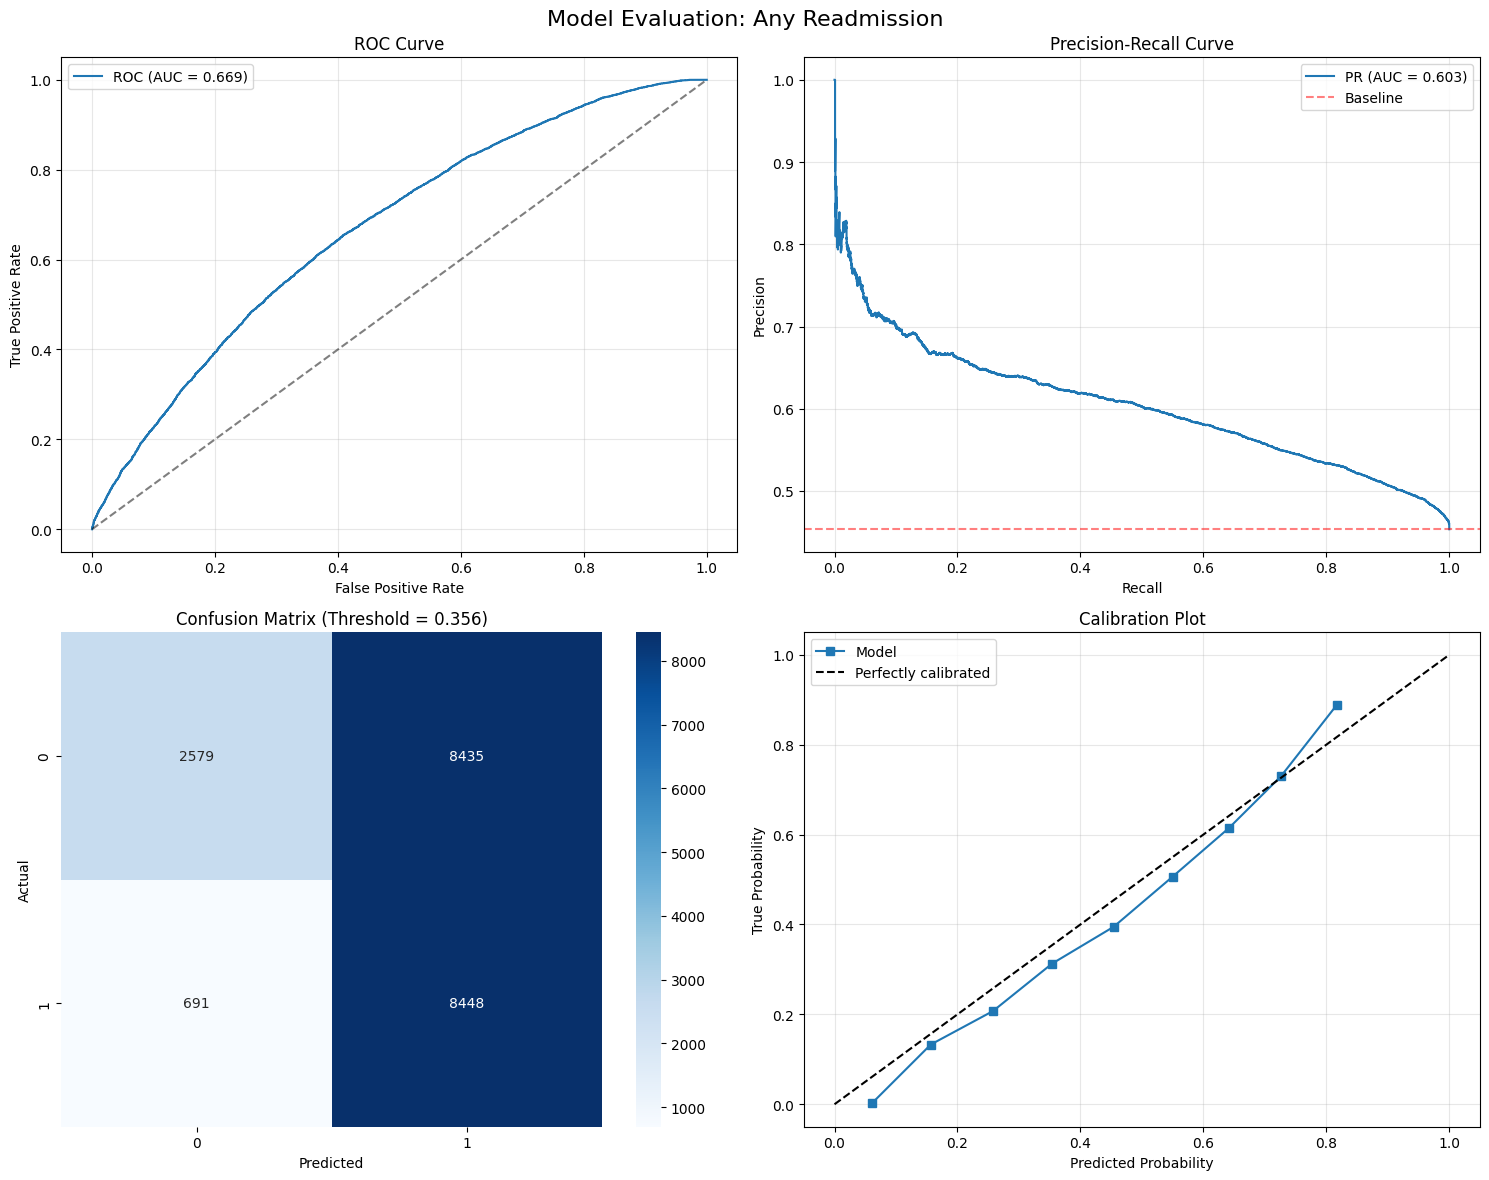

In [41]:
def plot_comprehensive_evaluation(results, model_name):
    """Create comprehensive evaluation plots"""
    
    y_test = results['y_test']
    y_pred_prob = results['y_pred_prob']
    optimal_threshold = results['optimal_threshold']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    axes[0,0].plot(fpr, tpr, label=f'ROC (AUC = {results["roc_auc"]:.3f})')
    axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('ROC Curve')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    axes[0,1].plot(recall, precision, label=f'PR (AUC = {results["pr_auc"]:.3f})')
    axes[0,1].axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', 
                     label='Baseline', alpha=0.5)
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision-Recall Curve')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix (Optimal Threshold)
    cm = results['cm_optimal']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_xlabel('Predicted')
    axes[1,0].set_ylabel('Actual')
    axes[1,0].set_title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
    
    # 4. Probability Calibration
    prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
    axes[1,1].plot(prob_pred, prob_true, 's-', label='Model')
    axes[1,1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    axes[1,1].set_xlabel('Predicted Probability')
    axes[1,1].set_ylabel('True Probability')
    axes[1,1].set_title('Calibration Plot')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Model Evaluation: {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot evaluations
plot_comprehensive_evaluation(results_binary, "<30 Day Readmission")
plot_comprehensive_evaluation(results_any, "Any Readmission")

## Business Interpretation & Recommendations

In [42]:
def business_interpretation(results, model_name):
    """Provide business-focused interpretation"""
    
    y_test = results['y_test']
    y_pred_optimal = (results['y_pred_prob'] >= results['optimal_threshold']).astype(int)
    cm = results['cm_optimal']
    
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    prevalence = y_test.mean()
    
    print(f"\n{model_name.upper()} - BUSINESS IMPACT:")
    print(f"• Prevalence: {prevalence:.1%}")
    print(f"• Patients flagged for intervention: {(tp+fp)/total:.1%}")
    print(f"• Precision: Of those flagged, {tp/(tp+fp):.1%} will actually readmit")
    print(f"• Recall: We catch {tp/(tp+fn):.1%} of all readmissions")
    print(f"• Efficiency: For every 10 interventions, we prevent ~{tp/(tp+fp)*10:.1f} readmissions")
    
    if model_name == "<30 Day Readmission":
        if results['pr_auc'] > 0.25:
            print(" MODEL IS CLINICALLY USEFUL - Can effectively target interventions")
        else:
            print("⚠️ MODEL NEEDS IMPROVEMENT - High false positive rate may cause alert fatigue")

# Provide business interpretation
business_interpretation(results_binary, "<30 Day Readmission")
business_interpretation(results_any, "Any Readmission")


<30 DAY READMISSION - BUSINESS IMPACT:
• Prevalence: 10.7%
• Patients flagged for intervention: 35.3%
• Precision: Of those flagged, 15.8% will actually readmit
• Recall: We catch 52.3% of all readmissions
• Efficiency: For every 10 interventions, we prevent ~1.6 readmissions
⚠️ MODEL NEEDS IMPROVEMENT - High false positive rate may cause alert fatigue

ANY READMISSION - BUSINESS IMPACT:
• Prevalence: 45.3%
• Patients flagged for intervention: 83.8%
• Precision: Of those flagged, 50.0% will actually readmit
• Recall: We catch 92.4% of all readmissions
• Efficiency: For every 10 interventions, we prevent ~5.0 readmissions


## Save Results & Model

In [44]:
print("\n SAVING RESULTS...")

# Save cleaned dataset
output_df = pd.concat([X, y_binary, y_any, groups], axis=1)
output_df.to_csv("cleaned_diabetes_readmission_data.csv", index=False)

# Save feature importance
importance_binary.to_csv("feature_importance.csv", index=False)

print(" WORKFLOW COMPLETED SUCCESSFULLY!")
print("\n📋 SUMMARY:")
print(f"• Final features: {len(all_features)}")
print(f"• Best <30-day model ROC-AUC: {results_binary['roc_auc']:.4f}")
print(f"• Best <30-day model PR-AUC: {results_binary['pr_auc']:.4f}")
print(f"• Dataset saved: cleaned_diabetes_readmission_data.csv")

# Show final data snapshot
print(f"\nFinal dataset shape: {output_df.shape}")
print(f"Final features: {list(X.columns)}")


 SAVING RESULTS...
 WORKFLOW COMPLETED SUCCESSFULLY!

📋 SUMMARY:
• Final features: 50
• Best <30-day model ROC-AUC: 0.6392
• Best <30-day model PR-AUC: 0.1775
• Dataset saved: cleaned_diabetes_readmission_data.csv

Final dataset shape: (101766, 53)
Final features: ['age_num', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'num_medications_steady', 'num_medications_changed', 'any_med_change', 'on_insulin', 'change_flag', 'diabetesMed_flag', 'long_stay', 'many_procedures', 'many_medications', 'many_diagnoses', 'high_lab_work', 'race_enc', 'gender_enc', 'medical_specialty_enc', 'admission_type_id_enc', 'discharge_disposition_id_enc', 'admission_source_id_enc', 'A1Cresult_enc', 'diag_1_group_enc', 'diag_2_group_enc', 'diag_3_group_enc', 'metformin_code', 'repaglinide_code', 'nateglinide_code', 'chlorpropamide_code', 'glimepiride_code', 'acetohexamide_code', 'glipizide_code', 'glyburide_code', 'tolbutamide_code', 'pioglitazone_code', 'ros